In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Fraud Detection Zindi Project

By Atwine Mugume

Some of the resources used here include these articles that educate on imbalanced data

- [Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
- [Handling Imbalanced Datasets: Predicting Credit Card Fraud](https://medium.com/coinmonks/handling-imbalanced-datasets-predicting-credit-card-fraud-544f5e74e0fd)
- [Tackling Class Imbalance](https://www.kaggle.com/shahules/tackling-class-imbalance)  thanks to Shahules786's kernel
- [Great article on scaling data](https://www.kaggle.com/discdiver/guide-to-scaling-and-standardizing?source=post_page---------------------------)
-[performance-metrics-for-classification-problems](https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b)


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

%time
print('Importing fastai libraries')
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

print('Done!')

['training.csv', 'test.csv', '.ipynb_checkpoints', 'Xente_Variable_Definitions.csv', 'fastai-xente-project-v.ipynb', 'Random Forest Classifier.ipynb']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs
Importing fastai libraries
Done!


In [3]:
#let's take a quick look at the data
#since we have a time variable we have to parse the dates
train = pd.read_csv('./training.csv', low_memory=True, 
                     parse_dates=["TransactionStartTime"])
test = pd.read_csv('./test.csv',low_memory=True, 
                     parse_dates=["TransactionStartTime"])

print('Done Readind the data!')

Done Readind the data!


In [4]:
#let's have a description of the variables here to keep refering to them
feature_desc = pd.read_csv('./Xente_Variable_Definitions.csv')
feature_desc

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


In [5]:
#what does the data look like
train.shape,test.shape

((95662, 16), (45019, 15))

There are datasets which we have to look at carefully because they have a time variable. We have to make sure the time is progressive.
That is we are having the first rows from a time before those at the end of the dataset

For example if the first row is on the date 9/Jan/2019 the last row should not be the same date...it should be maybe 25/Oct/2021 so we can have a progression. 

Therefore our model will be used to tell the future.

In [6]:
#let's have a snippet of the head of the two datasets
train.head(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


In [9]:
train.tail(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13 09:54:09+00:00,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13 09:54:25+00:00,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13 09:54:35+00:00,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13 10:01:10+00:00,2,0
95661,TransactionId_35670,BatchId_29317,AccountId_4841,SubscriptionId_3829,CustomerId_1709,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13 10:01:28+00:00,2,0


In [10]:
#let's get snippet of the test data
test.head(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13 10:01:40+00:00,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13 10:02:12+00:00,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13 10:02:30+00:00,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13 10:02:38+00:00,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13 10:02:58+00:00,2


In [11]:
test.tail(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
45014,TransactionId_116198,BatchId_117348,AccountId_4841,SubscriptionId_3829,CustomerId_5225,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000.0,5000,2019-03-14 23:56:28+00:00,2
45015,TransactionId_24829,BatchId_53630,AccountId_4803,SubscriptionId_1738,CustomerId_5272,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000.0,10000,2019-03-14 23:57:38+00:00,1
45016,TransactionId_102920,BatchId_112209,AccountId_4817,SubscriptionId_4613,CustomerId_5286,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000.0,10000,2019-03-14 23:59:17+00:00,1
45017,TransactionId_128439,BatchId_58734,AccountId_4841,SubscriptionId_3829,CustomerId_5286,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000.0,5000,2019-03-14 23:59:39+00:00,2
45018,TransactionId_45927,BatchId_98308,AccountId_4593,SubscriptionId_3866,CustomerId_5057,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,3500.0,3500,2019-03-14 23:59:51+00:00,4


In [12]:
#Let's take a peek at the data into
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null datetime64[ns, UTC]
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(10)
memory usage: 11.7+ MB


In [13]:
#Let's look at the shapes of the data
train.shape, test.shape

((95662, 16), (45019, 15))

## Initial Data Analysis

### Encoding

I have only discovered that the way you encode the data you have can affect how well your model will function. I have found some great resources here in these [article](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)

-This article is also a [good one](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)

What stands out the most is these two points:

- Categorical features with large cardinalities/features (over 1000): `Binary Encoding` is ideal
- Categorical features with small cardinalities/features (less than 1000): `Numeric Encoding` is ideal

As an esample here is a code below from the library: binaryencoder

```python 
from category_encoders import *
import pandas as pd
from sklearn.datasets import load_boston

# prepare some data
bunch = load_boston()
y = bunch.target
X = pd.DataFrame(bunch.data, columns=bunch.feature_names)

# use binary encoding to encode two categorical features
enc = BinaryEncoder(cols=['CHAS', 'RAD']).fit(X)

# transform the dataset
numeric_dataset = enc.transform(X)


## A supervised example

from category_encoders import *
import pandas as pd
from sklearn.datasets import load_boston

# prepare some data
bunch = load_boston()
y_train = bunch.target[0:250]
y_test = bunch.target[250:506]
X_train = pd.DataFrame(bunch.data[0:250], columns=bunch.feature_names)
X_test = pd.DataFrame(bunch.data[250:506], columns=bunch.feature_names)

# use target encoding to encode two categorical features
enc = TargetEncoder(cols=['CHAS', 'RAD']).fit(X_train, y_train)

# transform the datasets
training_numeric_dataset = enc.transform(X_train, y_train)
testing_numeric_dataset = enc.transform(X_test)


```

In [14]:
#how unique is the batchId?
#i need to know if I should leave it in the conversation
for col in train.columns:
    print(col,'has', train[col].nunique())

TransactionId has 95662
BatchId has 94809
AccountId has 3633
SubscriptionId has 3627
CustomerId has 3742
CurrencyCode has 1
CountryCode has 1
ProviderId has 6
ProductId has 23
ProductCategory has 9
ChannelId has 4
Amount has 1676
Value has 1517
TransactionStartTime has 94556
PricingStrategy has 4
FraudResult has 2


In [15]:
#let's install the package with the encoders that make sense for this kind of data with only 10+ features
#%pip install category_encoders

## Lil Function

One fo the things I have learnt is to make code reusable, so I am going to write a function that will help us encode without having to repeat the code so much.

`Why is this function so important?`

I have been having memory issues wen I use the pd.getdummies. 
I normally have memory limited to 13Gb and as a result this method of replacing the categorical values with simple codes keeps the memory usage under 200Mbs. Which is quite phenomenal

In [16]:
#little function to help us encode data
def lil_encoder(df,col):
    df[col] = train[col].astype('category')
    
    #let's create a new column of the categorical features
    #df[col] = df[col].cat.codes
    
    return df.head(4)

In [17]:
#we need to keep the ids of the test data
fin_Id = test['TransactionId']
y = train['FraudResult']

#let's now drop them from their original datasets
test = test.drop(columns=['TransactionId'])
train = train.drop(columns=['FraudResult','TransactionId'])

In [18]:
#i want to see if the datasets are aligned, when they are not aligned one gets problems in fitting the data
train.shape, test.shape

((95662, 14), (45019, 14))

In [19]:
test.head(4)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13 10:01:40+00:00,4
1,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13 10:02:12+00:00,2
2,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13 10:02:30+00:00,2
3,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13 10:02:38+00:00,4


In [20]:
#let me put the datasets together so that I can work on them at the same time
train['Identifier']='Train'
test['Identifier']='Test'

ls = [train, test]
data = pd.concat(ls)
data.head(5)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,Identifier
0,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,Train
1,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,Train
2,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,Train
3,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,Train
4,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,Train


In [21]:
#let's encode all the data
ls_ = ['AccountId','CustomerId','ProviderId','ProductId','ProductCategory','ChannelId','BatchId','SubscriptionId']

#this is the for loop that calls the function and makes the lil_function work
for col in ls_:
    lil_encoder(data,col)

We now have all the columns in the list above transformed from object to categorical, now we are going to encode them with a categorical encoder. I have chosen to update my encoding method because of some of the articles I have read on this topic, they insist that we shd use Binary encoders for small datasets

In [22]:
from category_encoders import *

# use binary encoding to encode two categorical features
enc = BinaryEncoder(cols=['AccountId','CustomerId','ProviderId','ProductId','ProductCategory','ChannelId','BatchId','SubscriptionId']).fit(data)

data = enc.transform(data)


In [23]:
data.head(5)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,ProductCategory_3,ProductCategory_4,ChannelId_0,ChannelId_1,ChannelId_2,Amount,Value,TransactionStartTime,PricingStrategy,Identifier
0,0,0,1,0,1,1,0,1,1,1,...,0,1,0,1,1,1000.0,1000,2018-11-15 02:18:49+00:00,2,Train
1,0,0,0,1,1,1,1,1,0,0,...,1,1,0,1,0,-20.0,20,2018-11-15 02:19:08+00:00,2,Train
2,0,0,1,1,1,0,1,0,1,1,...,0,1,0,1,1,500.0,500,2018-11-15 02:44:21+00:00,2,Train
3,0,0,0,0,0,0,0,1,1,1,...,0,1,0,1,1,20000.0,21800,2018-11-15 03:32:55+00:00,2,Train
4,0,0,1,0,1,1,1,1,1,1,...,1,1,0,1,0,-644.0,644,2018-11-15 03:34:21+00:00,2,Train


In [24]:
#dropping some features: there are some features we can see that will not contribute to the ML process

#let's split the data
train = data[data['Identifier']=='Train']
test = data[data['Identifier']=='Test']

#now let's drop the useless columns from the datasets
train = train.drop(columns=['CurrencyCode','CountryCode','Amount'])
test = test.drop(columns=['CurrencyCode','CountryCode','Amount'])

#let's see the new shapes
train.shape, test.shape

((95662, 79), (45019, 79))

In [25]:
test.head(3)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,ProductCategory_2,ProductCategory_3,ProductCategory_4,ChannelId_0,ChannelId_1,ChannelId_2,Value,TransactionStartTime,PricingStrategy,Identifier
0,0,0,1,0,1,1,0,1,1,1,...,0,0,1,0,1,1,1000,2019-02-13 10:01:40+00:00,4,Test
1,0,0,0,1,1,1,1,1,0,0,...,0,1,1,0,1,0,2000,2019-02-13 10:02:12+00:00,2,Test
2,0,0,1,1,1,0,1,0,1,1,...,0,0,1,0,1,1,50,2019-02-13 10:02:30+00:00,2,Test


I have tried to load the date time function from fastai but it has failed so i am going to copy it manually and use it here.

In [26]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.

    Examples:
    ---------

    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df

        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13

    >>> add_datepart(df, 'A')
    >>> df

        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [27]:
#let's add the datetime variables
#this is a function in the fastai lib that deals with all variables of time, ie it converts the datatime column into many others
add_datepart(test,'TransactionStartTime')
add_datepart(train,'TransactionStartTime')

In [28]:
#let's have a look at the dataframe now and see how its looks like after we add the datetime variables
train.head(4)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,TransactionStartTimeDay,TransactionStartTimeDayofweek,TransactionStartTimeDayofyear,TransactionStartTimeIs_month_end,TransactionStartTimeIs_month_start,TransactionStartTimeIs_quarter_end,TransactionStartTimeIs_quarter_start,TransactionStartTimeIs_year_end,TransactionStartTimeIs_year_start,TransactionStartTimeElapsed
0,0,0,1,0,1,1,0,1,1,1,...,15,3,319,False,False,False,False,False,False,1542248329
1,0,0,0,1,1,1,1,1,0,0,...,15,3,319,False,False,False,False,False,False,1542248348
2,0,0,1,1,1,0,1,0,1,1,...,15,3,319,False,False,False,False,False,False,1542249861
3,0,0,0,0,0,0,0,1,1,1,...,15,3,319,False,False,False,False,False,False,1542252775


In [29]:
#let's remove the identifier columns so that we have only the features we need to use otherwise we will have problems.
train = train.drop(columns='Identifier')
test = test.drop(columns='Identifier')

In [30]:
train.head(4)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,TransactionStartTimeDay,TransactionStartTimeDayofweek,TransactionStartTimeDayofyear,TransactionStartTimeIs_month_end,TransactionStartTimeIs_month_start,TransactionStartTimeIs_quarter_end,TransactionStartTimeIs_quarter_start,TransactionStartTimeIs_year_end,TransactionStartTimeIs_year_start,TransactionStartTimeElapsed
0,0,0,1,0,1,1,0,1,1,1,...,15,3,319,False,False,False,False,False,False,1542248329
1,0,0,0,1,1,1,1,1,0,0,...,15,3,319,False,False,False,False,False,False,1542248348
2,0,0,1,1,1,0,1,0,1,1,...,15,3,319,False,False,False,False,False,False,1542249861
3,0,0,0,0,0,0,0,1,1,1,...,15,3,319,False,False,False,False,False,False,1542252775


In [31]:
#let's see the shapes of the data now
train.shape, test.shape

((95662, 90), (45019, 90))

In [32]:
#let's attach the y column to find correlations and after remove
train['FraudResult']= y
# Find correlations with the target and sort
correlations = train.corr()['FraudResult'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))


Most Positive Correlations:
 SubscriptionId_2     0.033930
ChannelId_2          0.034272
ProductId_3          0.035686
ProductId_5          0.045169
ProductId_4          0.049997
ProviderId_3         0.074962
Value                0.566739
FraudResult          1.000000
BatchId_0                 NaN
AccountId_0               NaN
SubscriptionId_0          NaN
CustomerId_0              NaN
ProviderId_0              NaN
ProductId_0               NaN
ProductCategory_0         NaN
Name: FraudResult, dtype: float64

Most Negative Correlations:
 ProviderId_1                    -0.083548
ProductId_1                     -0.049321
PricingStrategy                 -0.033821
SubscriptionId_1                -0.029144
SubscriptionId_4                -0.028527
AccountId_2                     -0.023884
AccountId_10                    -0.021586
CustomerId_7                    -0.014871
SubscriptionId_11               -0.010745
CustomerId_10                   -0.010288
CustomerId_2                    -0.01

In [33]:
#I really don't have much issue with correlation
y = train['FraudResult']
train = train.drop(columns='FraudResult')

## Creating a Validation set

We are going to take the last 20,000 values and keep them for validation. We want to use this information to make sure we are checkin properly if our models are doing well on out of sample data.

In [34]:
#lets first mix the train and lable
train['FraudResult']= y

#choose the last 20k rows to be kept aside
valid = train.tail(20000)

#bread the validation set into X and y
y_valid = valid['FraudResult']
X_valid = valid.drop(columns='FraudResult')

In [35]:
valid.head(4)

,BatchId_0,BatchId_1,BatchId_2,BatchId_3,BatchId_4,BatchId_5,BatchId_6,BatchId_7,BatchId_8,BatchId_9,...,TransactionStartTimeDayofweek,TransactionStartTimeDayofyear,TransactionStartTimeIs_month_end,TransactionStartTimeIs_month_start,TransactionStartTimeIs_quarter_end,TransactionStartTimeIs_quarter_start,TransactionStartTimeIs_year_end,TransactionStartTimeIs_year_start,TransactionStartTimeElapsed,FraudResult
75662,0,0,0,0,0,1,1,0,0,1,...,0,28,False,False,False,False,False,False,1548656268,0
75663,0,0,0,0,0,1,0,0,0,1,...,0,28,False,False,False,False,False,False,1548656287,0
75664,0,0,0,1,0,1,1,0,1,1,...,0,28,False,False,False,False,False,False,1548656326,0
75665,0,0,0,1,0,1,0,0,1,0,...,0,28,False,False,False,False,False,False,1548656337,0


In [36]:
valid.shape

(20000, 91)

In [37]:
'FraudResult' in X_valid.columns

False

In [38]:
#lets now take the ones for validation out of the major dataset

train  = train.iloc[0:75662, ]

y = train['FraudResult']
train = train.drop(columns='FraudResult')

In [39]:
train.shape, X_valid.shape


((75662, 90), (20000, 90))

### Imbalance in data:
There is a problem we have with the target variable, we have more of one result than the other, that is we have less fraud cases than the where there was actually fraud.

We have to handle this data in a different way.

Text(0.5, 1.0, 'Target variable count')

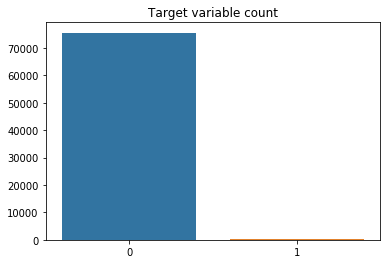

In [40]:
#i want to visualize the imbalance in the target variable
x=y.value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

## Smote: Oversampling data:

`SMOTE (Synthetic Minority Oversampling TEchnique)` consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [41]:
#First we are going to separate the target variable from the rest of the observations and split the data
from sklearn.model_selection import train_test_split

x = train

#split the data to prevent overfitting
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=1)

#let's see the shape of the data
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((60529, 90), (15133, 90), (60529,), (15133,))

In [42]:
#%pip install imblearn

In [43]:
#first we are going to filter out the different results from the label in the main label

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=27,ratio='minority')
X_train, y_train = smote.fit_sample(X_train, y_train)

In [44]:
#Let's see the shape
X_train.shape, y_train.shape

((120846, 90), (120846,))

In [45]:
#let's check and see the number of os and ones
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (120846, 90)
After OverSampling, the shape of train_y: (120846,) 

After OverSampling, counts of label '1': 60423
After OverSampling, counts of label '0': 60423


### Let's take a test run at the data

In [46]:
#now we have something to put in the model
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
m.score(X_train, y_train)

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9999751750161362

### Score Function

In [47]:
#I want to write a function that I will call to evaluate my model, I am going to evaluate based on ROC_AUC and score.

#when you build a model you want to know how it is functioning. And there are functions that are pre_built in scikit learn 
#to help you evaluate the model, so I built these in the functions below

def print_score(m,md):
    
    # Used to ignore warnings generated from StackingCVClassifier
    import warnings
    warnings.simplefilter('ignore')

    #Call the classification metrics we want to use
    from sklearn.metrics import roc_auc_score,auc,f1_score,roc_curve
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, m)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    f1 = f1_score(y_test,m)
    roc = roc_auc_score(y_test,m)
    #oob = md.oob_score_ #I added the oob score
    
    #let's see how the model does on validation data
    pred = md.predict(X_valid)
    f2 = f1_score(y_valid,pred)
    
    pred_3 = md.predict(X_train)
    f3 = f1_score(y_train,pred_3)
    
    res = ["roc_auc-->",roc_auc,"F1_score-->",f1,"roc_auc_score-->",roc]
    print(res)
    print('\n')
    
    print("Model Performance on out of sample data")
    
    valid = ['Valid_data_F1_score-->',f2]
    
    print(valid)
    
    print('\n')
    
    print("Model Performance on train data")
    
    train_ = ['Train_data_F1_score-->',f3]
    
    print(train_)
    
    
    print('\n')
    print('--'*10)
    print('Scores on the Validation Data according to the Confusion_matrix')
    
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_valid,pred).ravel()
    
    # Error rate : 
    err_rate = (fp + fn) / (tp + tn + fn + fp)
    print("Error rate  : ", err_rate)

    # Accuracy : 
    acc_ = (tp + tn) / (tp + tn + fn + fp)
    print("Accuracy  : ", acc_)
    
    
    #precision
    preci_ = tp / (tp + fp)
    print("Precision  : ", preci_)

    # Sensitivity : 
    sens_ = tp / (tp + fn)
    print("Recall  : ", sens_)

    # Specificity 
    sp_ = tn / (tn + fp)
    print("Specificity  : ", sens_)

    # False positive rate (FPR)
    FPR = fp / (tn + fp)
    print("False positive rate  : ", FPR)
    
    # False positive rate (FPR)
    TPR = tp / (tp + fn)
    print("True positive rate  : ", TPR)
    
    print('--'*10)
    
    
    print('\n')
    print('Drawing the Confusion Matrix on Test_data')
    #from sklearn.metrics import confusion_matrix
    
    plt.figure(figsize=(7,7))
    cm_2 = confusion_matrix(y_test,m)
    sns.heatmap(cm_2,annot=True,fmt="d")
   

## Baseline Models

Here we are going to use crossvalidation to run baseline models and set a stndard of what we are going to do we are going to use three models:

1- Random Forest Classifier
2- Light Gradient Boosting Machine
3- X Gradient Bosting Machine

In [48]:
#thee are the necessary libraries we will need

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from timeit import default_timer as timer

### Random Forest

In [51]:
#Random Forest Classifier with Cross val

rf_ = RandomForestClassifier()

start = timer()
cv = cross_val_score(estimator = rf_, X = X_train, 
                     y = y_train, 
                     verbose = 2, n_jobs = -1, 
                     cv = 10, scoring = 'f1')
cv_time = timer() - start

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    5.9s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.5s finished


In [52]:
print('Baseline model 10 fold cv F1_score: {:.5f}'.format(np.mean(cv)))
print('Baseline model eval time: {:.2f} seconds.'.format(cv_time))

Baseline model 10 fold cv F1_score: 0.99948
Baseline model eval time: 6.48 seconds.


### Light Gradient Boosting Machine

In [54]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier()

start = timer()
cv = cross_val_score(estimator = model_lgb, X = X_train, 
                     y = y_train, 
                     verbose = 2, n_jobs = -1, 
                     cv = 10, scoring = 'f1')
cv_time = timer() - start


print('Baseline model 10 fold cv F1_score: {:.5f}'.format(np.mean(cv)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    9.9s remaining:   23.0s


Baseline model 10 fold cv F1_score: 0.99977


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.8s finished


### X Gradient Boosting Machine

In [56]:
#%pip install xgboost

    100% |████████████████████████████████| 142.8MB 9.6kB/s 
Note: you may need to restart the kernel to use updated packages.


In [57]:
from xgboost.sklearn import XGBRFClassifier

In [58]:
xgb = XGBRFClassifier()

start = timer()
cv = cross_val_score(estimator = xgb, X = X_train, 
                     y = y_train, 
                     verbose = 0, n_jobs = -1, 
                     cv = 10, scoring = 'f1')
cv_time = timer() - start


print('Baseline model 10 fold cv F1_score: {:.5f}'.format(np.mean(cv)))

Baseline model 10 fold cv F1_score: 0.99144


### Model Tuning

From here on, we embark in tuning the above models such that they will be able to generalize properly, what we have above maybe overfitted models that may not generalize well on out of sample data.

CPU times: user 8min 24s, sys: 292 ms, total: 8min 24s
Wall time: 32.4 s
['roc_auc-->', 0.8094245506566841, 'F1_score-->', 0.7027027027027026, 'roc_auc_score-->', 0.8094245506566841]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.0]


Model Performance on train data
['Train_data_F1_score-->', 1.0]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.0033
Accuracy  :  0.9967
Precision  :  nan
Recall  :  0.0
Specificity  :  0.0
False positive rate  :  0.0
True positive rate  :  0.0
--------------------


Drawing the Confusion Matrix on Test_data


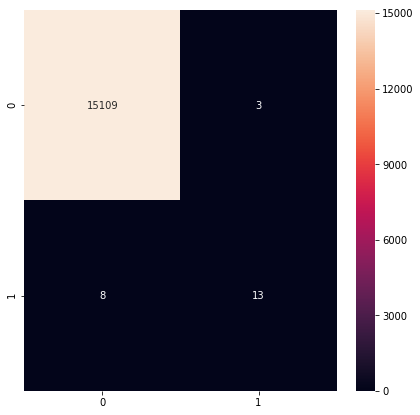

In [46]:
ml = RandomForestClassifier(n_jobs=-1, n_estimators=1060, max_features='sqrt',random_state=20)
%time ml.fit(X_train, y_train)
pred_d = ml.predict(X_test)
print_score(pred_d,ml)

In [49]:
#classifiers
from sklearn.ensemble import RandomForestClassifier

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_curve, auc,f1_score

#we are going to use cross validation
from sklearn.model_selection import KFold, RepeatedStratifiedKFold


In [48]:
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 50)]
# Number of features to consider at every split
max_features = [float(x) for x in np.linspace(start = 0.4, stop = 0.85, num = 50)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 20, num = 20)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [4,
               4,
               5,
               6,
               7,
               8,
               9,
               9,
               10,
               11,
               12,
               13,
               14,
               14,
               15,
               16,
               17,
               18,
               19,
               20],
 'max_features': [0.4,
                  0.4091836734693878,
                  0.41836734693877553,
                  0.4275510204081633,
                  0.43673469387755104,
                  0.4459183673469388,
                  0.45510204081632655,
                  0.4642857142857143,
                  0.47346938775510206,
                  0.4826530612244898,
                  0.49183673469387756,
                  0.5010204081632653,
                  0.5102040816326531,
                  0.5193877551020408,
                  0.5285714285714286,
                  0.5377551020408163,
       

In [49]:
#let's see what we get on the cross validation score without the random search
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(RandomForestClassifier(),
                        X_train, y_train, cv=10))

0.9994952728440769

KFold Cross Validation score

In [74]:
#k-fold cross validation score
#np.mean(cross_val_score(RandomForestClassifier(n_jobs=-1, n_estimators=1060, max_features='sqrt'),
#                X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42)))

Repeated Stratified KFold

In [ ]:
#np.mean(cross_val_score(RandomForestClassifier(),
#                X_train, y_train,
#                cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)))

I need to subset the data so the process won't take so long

In [50]:
def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.

    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.

    Returns:
    --------
    return value: A random sample of n rows of df.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [51]:
#we now take samples of the whole dataset without replacing
X_train_sample = get_sample(pd.DataFrame(X_train), 20000)
y_train_sample = get_sample(pd.DataFrame(y_train), 20000)

X_test_sample = get_sample(pd.DataFrame(X_test), 20000)
y_test_sample = get_sample(pd.DataFrame(y_test), 20000)

In [52]:
rm_clf = RandomForestClassifier(random_state=42)


# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid = RandomizedSearchCV(rm_clf, param_distributions=random_grid,
                              n_iter = 100, scoring='f1', 
                              cv =KFold(n_splits=10, shuffle=True, random_state=42), verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit GridSearchCV
%time
grid.fit(X_train_sample, y_train_sample)


y_pred = grid.predict(X_test_sample)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_sample, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
f1 = f1_score(y_test_sample,y_pred)

# Print results
print("The ROC of the tuned classifier is",roc_auc)
print("The F1 of the tuned classifier is",f1)

print(grid.best_params_)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.7 µs
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 29.4min finished


The ROC of the tuned classifier is 0.9282074793919686
The F1 of the tuned classifier is 0.7200000000000001
{'min_samples_split': 5, 'min_samples_leaf': 2, 'n_estimators': 58, 'bootstrap': True, 'max_features': 0.45510204081632655, 'max_depth': 20}


CPU times: user 1min 28s, sys: 64 ms, total: 1min 28s
Wall time: 6.5 s
['roc_auc-->', 0.9522155209357432, 'F1_score-->', 0.8444444444444444, 'roc_auc_score-->', 0.9522155209357432]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.7350427350427351]


Model Performance on train data
['Train_data_F1_score-->', 0.99993380004303]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.00155
Accuracy  :  0.99845
Precision  :  0.8431372549019608
Recall  :  0.6515151515151515
Specificity  :  0.6515151515151515
False positive rate  :  0.0004013243704223939
True positive rate  :  0.6515151515151515
--------------------


Drawing the Confusion Matrix on Test_data


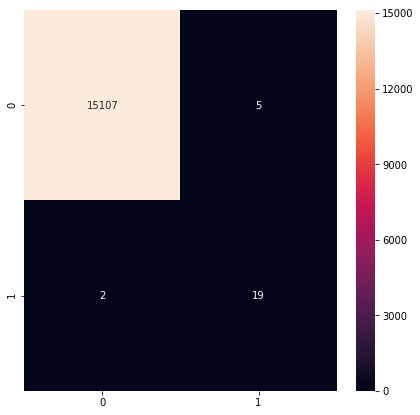

In [53]:
ml_rfeX = RandomForestClassifier(n_jobs=-1, n_estimators=58, min_samples_leaf=2,min_samples_split=5, max_features=0.45510204081632655, bootstrap=True, max_depth=20)
%time ml_rfeX.fit(X_train, y_train)
pred_d = ml_rfeX.predict(X_test)
print_score(pred_d,ml_rfeX)

### Third Result using 16 cores

CPU times: user 58.9 s, sys: 44 ms, total: 59 s
Wall time: 4.48 s
['roc_auc-->', 0.9520170032014923, 'F1_score-->', 0.7450980392156863, 'roc_auc_score-->', 0.9520170032014923]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.5765765765765766]


Model Performance on train data
['Train_data_F1_score-->', 0.9996525594785084]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.00235
Accuracy  :  0.99765
Precision  :  0.7111111111111111
Recall  :  0.48484848484848486
Specificity  :  0.48484848484848486
False positive rate  :  0.0006521521019363901
True positive rate  :  0.48484848484848486
--------------------


Drawing the Confusion Matrix on Test_data


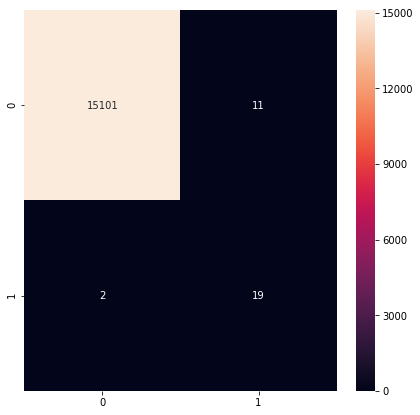

In [55]:
ml_rfe = RandomForestClassifier(n_jobs=-1, n_estimators=49, min_samples_leaf=2, max_features=0.45510204081632655, bootstrap=True, max_depth=10)
%time ml_rfe.fit(X_train, y_train)
pred_d = ml_rfe.predict(X_test)
print_score(pred_d,ml_rfe)

#### Second Results from the random Search

We still have a highly complex model but we are becoming better, I need to make the the model less complex on the training set so that we can generalize more

CPU times: user 1min 15s, sys: 44 ms, total: 1min 15s
Wall time: 5.39 s
['roc_auc-->', 0.9757603544329325, 'F1_score-->', 0.7407407407407407, 'roc_auc_score-->', 0.9757603544329325]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.5671641791044776]


Model Performance on train data
['Train_data_F1_score-->', 0.999561610296368]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.0029
Accuracy  :  0.9971
Precision  :  0.5588235294117647
Recall  :  0.5757575757575758
Specificity  :  0.5757575757575758
False positive rate  :  0.0015049663890839772
True positive rate  :  0.5757575757575758
--------------------


Drawing the Confusion Matrix on Test_data


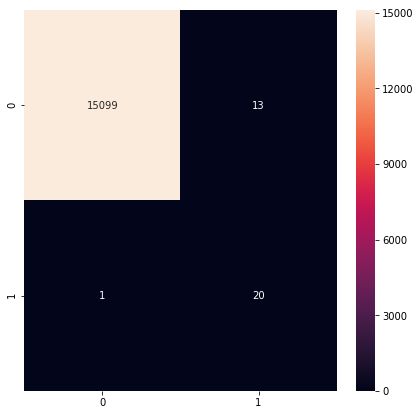

In [54]:
ml_rfeX = RandomForestClassifier(n_jobs=-1, n_estimators=49,  max_features=0.592857, bootstrap=True, max_depth=8)
%time ml_rfeX.fit(X_train, y_train)
pred_d = ml_rfeX.predict(X_test)
print_score(pred_d,ml_rfeX)

#### First Set of results from the random search

CPU times: user 1min 16s, sys: 68 ms, total: 1min 16s
Wall time: 5.3 s
['roc_auc-->', 0.9983787718369508, 'F1_score-->', 0.4615384615384615, 'roc_auc_score-->', 0.9983787718369508]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.3940298507462686]


Model Performance on train data
['Train_data_F1_score-->', 0.9981415249407353]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.01015
Accuracy  :  0.98985
Precision  :  0.24535315985130113
Recall  :  1.0
Specificity  :  1.0
False positive rate  :  0.010183605899468245
True positive rate  :  1.0
--------------------


Drawing the Confusion Matrix on Test_data


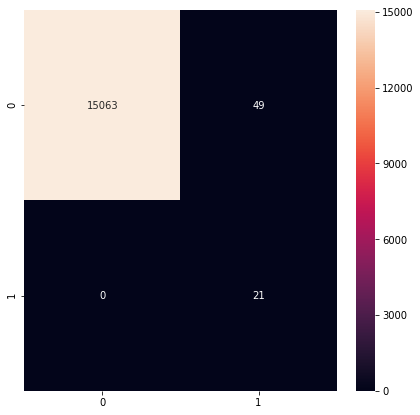

In [57]:
ml_a = RandomForestClassifier(n_jobs=-1, n_estimators=65,  max_features=0.66, bootstrap=True, max_depth=5)
%time ml_a.fit(X_train, y_train)
pred_d = ml_a.predict(X_test)
print_score(pred_d,ml_a)

## Feature Importances


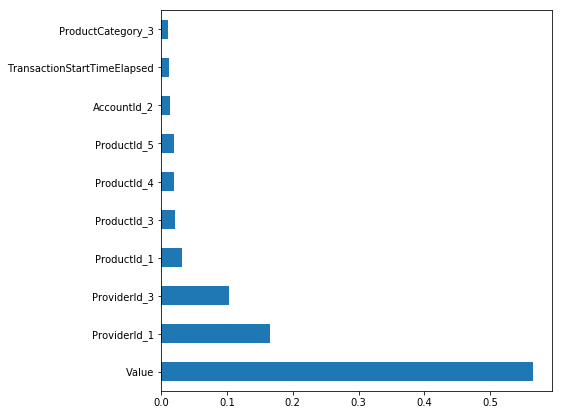

In [56]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(7,7))
feat_importances = pd.Series(ml_rfe.feature_importances_, index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Recursive Feature Elimination

In [57]:
#we are going to choose the top 20 features and use those ones to work with.
from sklearn.feature_selection import RFE
select = RFE(ml_rfe,n_features_to_select=10)


In [58]:
#we fit the new model based on the top 10 best features
select.fit(X_train_sample, y_train_sample)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=10,
                                     max_features=0.45510204081632655,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=2, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=49, n_jobs=-1,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

In [59]:
#let's get those features and use them in the model that we worked with before and see how it responds
X_train_rfe = select.transform(X_train_sample)
X_test_rfe = select.transform(X_test_sample)

X_valid_rfe= select.transform(X_valid)

In [60]:
def print_score_(m,md):
    
    # Used to ignore warnings generated from StackingCVClassifier
    import warnings
    warnings.simplefilter('ignore')

    #Call the classification metrics we want to use
    from sklearn.metrics import roc_auc_score,auc,f1_score,roc_curve
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_sample, m)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    f1 = f1_score(y_test_sample,m)
    roc = roc_auc_score(y_test_sample,m)
    #oob = md.oob_score_ #I added the oob score
    
    #let's see how the model does on validation data
    pred = md.predict(X_valid_rfe)
    f2 = f1_score(y_valid,pred)
    
    pred_3 = md.predict(X_train_rfe)
    f3 = f1_score(y_train_sample,pred_3)
    
    res = ["roc_auc-->",roc_auc,"F1_score-->",f1,"roc_auc_score-->",roc]
    print(res)
    print('\n')
    
    print("Model Performance on out of sample data")
    
    valid = ['Valid_data_F1_score-->',f2]
    
    print(valid)
    
    print('\n')
    
    print("Model Performance on train data")
    
    train_ = ['Train_data_F1_score-->',f3]
    
    print(train_)
    
    
    print('\n')
    print('--'*10)
    print('Scores on the Validation Data according to the Confusion_matrix')
    
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_valid,pred).ravel()
    
    # Error rate : 
    err_rate = (fp + fn) / (tp + tn + fn + fp)
    print("Error rate  : ", err_rate)

    # Accuracy : 
    acc_ = (tp + tn) / (tp + tn + fn + fp)
    print("Accuracy  : ", acc_)
    
    
    #precision
    preci_ = tp / (tp + fp)
    print("Precision  : ", preci_)

    # Sensitivity : 
    sens_ = tp / (tp + fn)
    print("Recall  : ", sens_)

    # Specificity 
    sp_ = tn / (tn + fp)
    print("Specificity  : ", sens_)

    # False positive rate (FPR)
    FPR = fp / (tn + fp)
    print("False positive rate  : ", FPR)
    
    # False positive rate (FPR)
    TPR = tp / (tp + fn)
    print("True positive rate  : ", TPR)
    
    print('--'*10)
    
    
    print('\n')
    print('Drawing the Confusion Matrix on Test_data')
    #from sklearn.metrics import confusion_matrix
    
    plt.figure(figsize=(7,7))
    cm_2 = confusion_matrix(y_test_sample,m)
    sns.heatmap(cm_2,annot=True,fmt="d")

['roc_auc-->', 0.8805222591948372, 'F1_score-->', 0.64, 'roc_auc_score-->', 0.8805222591948372]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.5380116959064327]


Model Performance on train data
['Train_data_F1_score-->', 0.9965283018867924]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.00395
Accuracy  :  0.99605
Precision  :  0.4380952380952381
Recall  :  0.696969696969697
Specificity  :  0.696969696969697
False positive rate  :  0.002959767231865155
True positive rate  :  0.696969696969697
--------------------


Drawing the Confusion Matrix on Test_data


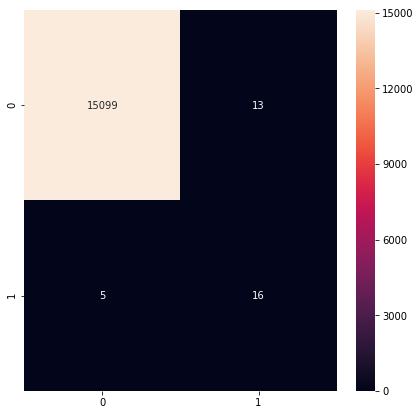

In [61]:
#so I am going to use the model that got us 81% before on the test data and see if we improve
ml_rfe = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=2, max_features=0.45510204081632655, bootstrap=True, max_depth=10, random_state=45)
ml_rfe.fit(X_train_rfe, y_train_sample)
pred_d = ml_rfe.predict(X_test_rfe)
print_score_(pred_d,ml_rfe)

### Grid Search based CV

Now that we have some information on the parameter ranges, lets  use the grid search

In [64]:
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 10000, num = 100)]
# Number of features to consider at every split
max_features = ['auto','log2','sqrt']#[float(x) for x in np.linspace(start = 0.4, stop = 0.85, num = 20)]
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(1, 10, 10)]
# Minimum number of samples required to split a node
min_samples_leaf = [int(x) for x in np.linspace(20, 300, 10)]
# Method of selecting samples for training each tree
#bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': [8],
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

#pprint(random_grid)

In [ ]:
rm_clf = RandomForestClassifier()

ls = []
max_iterations = 5
i = 0


while i<max_iterations:
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    grid = RandomizedSearchCV(rm_clf, param_distributions=random_grid,
                              n_iter = 10, 
                              scoring='f1', 
                              cv =KFold(n_splits=5, shuffle=True), 
                              verbose=2, 
                              #random_state=42, 
                              n_jobs=-1,
                              return_train_score=True)

    # Fit GridSearchCV

    grid.fit(X_train_rfe, y_train_sample)


    y_pred = grid.predict(X_test_rfe)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_sample, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    f1 = f1_score(y_test_sample,y_pred)
    
    ls.append([f1,grid.best_params_,roc_auc])
    i+=1

    # Print results
    #print("The ROC of the tuned classifier is",roc_auc)
    #print("The F1 of the tuned classifier is",f1)

    #print(grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  4.8min remaining:   32.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  5.1min remaining:   33.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min


In [90]:
pd.DataFrame(ls, columns=['F1_score', 'Parameters','ROC_AUC'])
#ls

[[0.56,
  {'bootstrap': True,
   'max_features': 'sqrt',
   'min_samples_leaf': 20,
   'n_estimators': 720}],
 [0.45652173913043476,
  {'bootstrap': True,
   'max_features': 'sqrt',
   'min_samples_leaf': 40,
   'n_estimators': 898}],
 [0.5833333333333334,
  {'bootstrap': True,
   'max_features': 'auto',
   'min_samples_leaf': 20,
   'n_estimators': 1226}],
 [0.5915492957746479,
  {'bootstrap': True,
   'max_features': 'sqrt',
   'min_samples_leaf': 20,
   'n_estimators': 1458}],
 [0.6,
  {'bootstrap': True,
   'max_features': 'sqrt',
   'min_samples_leaf': 20,
   'n_estimators': 1035}],
 [0.5833333333333334,
  {'bootstrap': True,
   'max_features': 'auto',
   'min_samples_leaf': 20,
   'n_estimators': 474}],
 [0.5915492957746479,
  {'bootstrap': True,
   'max_features': 'log2',
   'min_samples_leaf': 20,
   'n_estimators': 1281}],
 [0.5454545454545454,
  {'bootstrap': True,
   'max_features': 'sqrt',
   'min_samples_leaf': 20,
   'n_estimators': 433}],
 [0.5384615384615384,
  {'bootst

This is what I got after the time below: not impressive at all, however we are seeing something close between the score on the test and valid dataset

```
[Parallel(n_jobs=-1)]: Done 165856 tasks      | elapsed: 347.3min
[Parallel(n_jobs=-1)]: Done 171081 tasks      | elapsed: 362.5min
[Parallel(n_jobs=-1)]: Done 176386 tasks      | elapsed: 381.0min
[Parallel(n_jobs=-1)]: Done 180000 out of 180000 | elapsed: 395.6min finished

The ROC of the tuned classifier is 0.9757603544329325
The F1 of the tuned classifier is 0.7407407407407407
{'min_samples_leaf': 2, 'n_estimators': 17, 'max_depth': 9, 'max_features': 0.4, 'bootstrap': True}
```

I have looked at this [Article](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/) to see the best parameters to tune for Random 

['roc_auc-->', 0.9981802541026998, 'F1_score-->', 0.4329896907216495, 'roc_auc_score-->', 0.9981802541026998]


Model Performance on out of sample data
['Valid_data_F1_score-->', 0.4817518248175182]


Model Performance on train data
['Train_data_F1_score-->', 0.9884804167084043]


--------------------
Scores on the Validation Data according to the Confusion_matrix
Error rate  :  0.0071
Accuracy  :  0.9929
Precision  :  0.3173076923076923
Recall  :  1.0
Specificity  :  1.0
False positive rate  :  0.007123507574997492
True positive rate  :  1.0
--------------------


Drawing the Confusion Matrix on Test_data


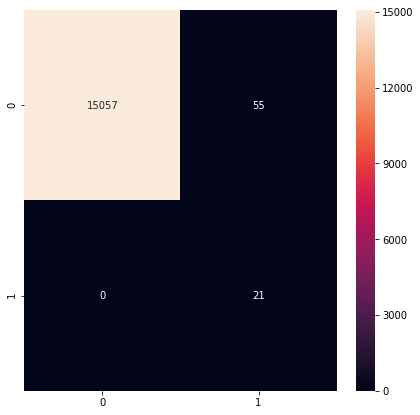

In [74]:
ml_ = RandomForestClassifier(n_jobs=-1, n_estimators=400, min_samples_leaf=50, max_features='auto', random_state=45)
ml_.fit(X_train_rfe, y_train_sample)
pred_d = ml_.predict(X_test_rfe)
print_score_(pred_d,ml_)